In [ ]:
# Import libraries
 
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [ ]:
# Our chosen list of ETFs

etfs = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'VNQ', 'TLT', 'IEF', 'GLD', 'USO']

# Adjusted prices from 2018 to 2024

prices = yf.download(etfs, start="2018-01-01", end="2024-01-01", group_by='ticker', auto_adjust=True)

adj_close_prices = prices.xs('Close', level=1, axis=1)

# Split into train and test periods

train_prices = adj_close_prices.loc[:'2022-12-31']
test_prices = adj_close_prices.loc['2023-01-01':]



[*********************100%***********************]  10 of 10 completed


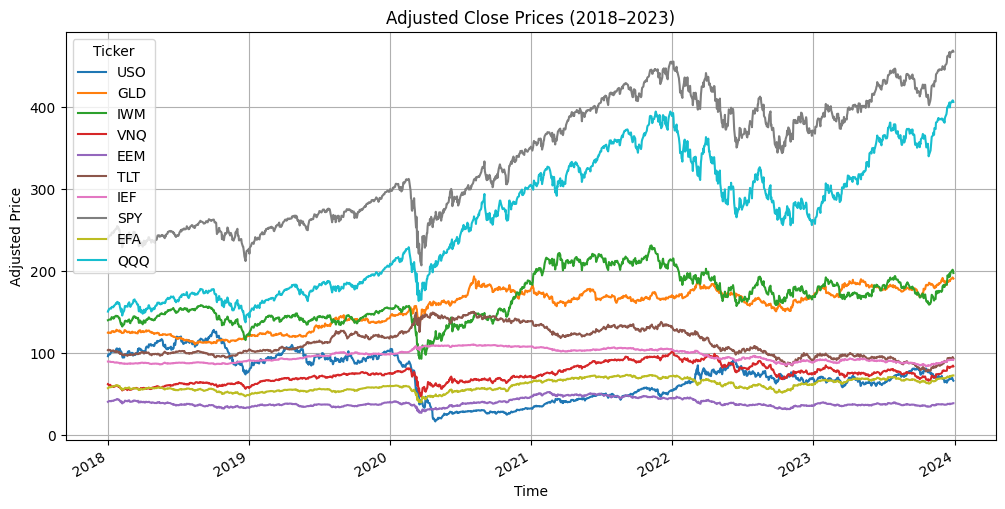

In [ ]:
# Visualization of price at close for these ETFs

adj_close_prices.plot(figsize=(12,6))
plt.title('Adjusted Close Prices (2018–2023)')
plt.xlabel('Time')
plt.ylabel('Adjusted Price')
plt.grid(True)
plt.show()

In [ ]:
# Daily returns

train_returns = train_prices.pct_change().dropna()
test_returns = test_prices.pct_change().dropna()

print("Training Period:", train_returns.index.min(), "to", train_returns.index.max())
print("Testing Period:", test_returns.index.min(), "to", test_returns.index.max())

Training Period: 2018-01-03 00:00:00 to 2022-12-30 00:00:00
Testing Period: 2023-01-04 00:00:00 to 2023-12-29 00:00:00


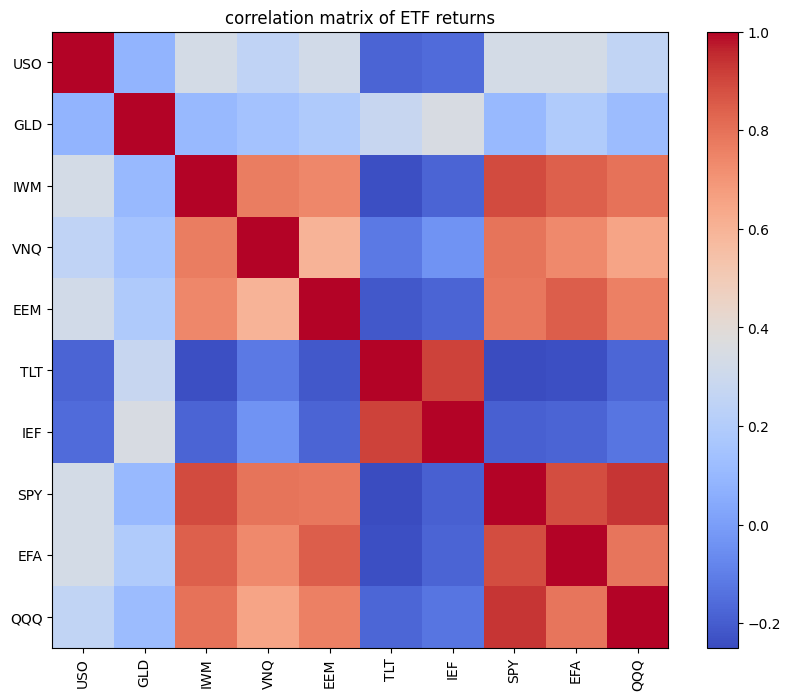

In [ ]:
# Plot correlation heatmap

plt.figure(figsize=(10,8))
plt.imshow(train_returns.corr(), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(train_returns.columns)), train_returns.columns, rotation=90)
plt.yticks(range(len(train_returns.columns)), train_returns.columns)
plt.title('correlation matrix of ETF returns')
plt.savefig("corr_matrix_etf_train_returns.png")
plt.show()


In [ ]:
# Calculate mean returns and cov matrix

mean_returns = train_returns.mean()
cov_matrix = train_returns.cov()

# Display

print("MEAN DAILY RETURNS (Training Period 2018–2023):")
print(mean_returns)

print("\nCOVARIANCE MATRIX (Training Period 2018–2023):")
print(cov_matrix)


MEAN DAILY RETURNS (Training Period 2018–2023):
Ticker
USO    1.441550e-04
GLD    2.827417e-04
IWM    2.890992e-04
VNQ    2.672507e-04
EEM    6.942997e-06
TLT   -5.018385e-05
IEF   -8.078049e-07
SPY    4.408914e-04
EFA    1.336807e-04
QQQ    5.764478e-04
dtype: float64

COVARIANCE MATRIX (Training Period 2018–2023):
Ticker       USO       GLD       IWM       VNQ       EEM       TLT       IEF  \
Ticker                                                                         
USO     0.000772  0.000021  0.000153  0.000108  0.000132 -0.000051 -0.000019   
GLD     0.000021  0.000082  0.000016  0.000021  0.000025  0.000026  0.000014   
IWM     0.000153  0.000016  0.000277  0.000198  0.000181 -0.000040 -0.000013   
VNQ     0.000108  0.000021  0.000198  0.000238  0.000135 -0.000018 -0.000003   
EEM     0.000132  0.000025  0.000181  0.000135  0.000215 -0.000031 -0.000011   
TLT    -0.000051  0.000026 -0.000040 -0.000018 -0.000031  0.000103  0.000040   
IEF    -0.000019  0.000014 -0.000013 -0.00

In [ ]:
# GOAL: minimize negative SR

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol
    return -sharpe


In [ ]:
# Constraints: weights must sum to 1

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: No short selling (weights between 0 and 1)

bounds = tuple((0, 1) for _ in range(len(etfs)))

# Initial guess: Equal weights

initial_weights = np.array(len(etfs) * [1. / len(etfs)])


In [ ]:
# Solve optimization

opt_result = minimize(negative_sharpe, initial_weights,
                      args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights

optimal_weights = opt_result.x



markowitz optimal portfolio allocation (2018-2023):
   ETF        Weight
0  SPY  0.000000e+00
1  QQQ  6.134766e-01
2  IWM  3.832722e-17
3  EFA  7.567503e-17
4  EEM  0.000000e+00
5  VNQ  3.621442e-17
6  TLT  4.166699e-16
7  IEF  3.667097e-03
8  GLD  0.000000e+00
9  USO  3.828563e-01


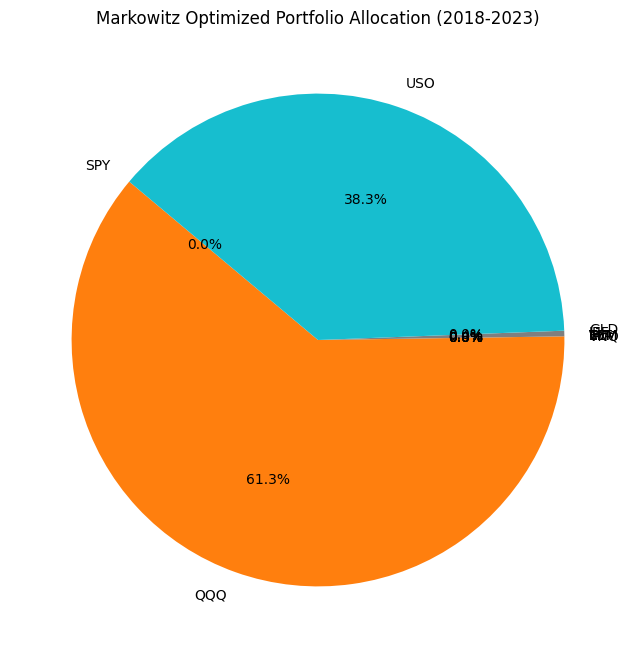

In [ ]:
# Show portfolio weights

portfolio = pd.DataFrame({'ETF': etfs, 'Weight': optimal_weights})

print("\nmarkowitz optimal portfolio allocation (2018-2023):")
print(portfolio)

# Pie chart of allocations

plt.figure(figsize=(8,8))
plt.pie(portfolio['Weight'], labels=portfolio['ETF'], autopct='%1.1f%%', startangle=140)
plt.title('Markowitz Optimized Portfolio Allocation (2018-2023)')
plt.savefig("markowitz_allocations_pie.png")
plt.show()


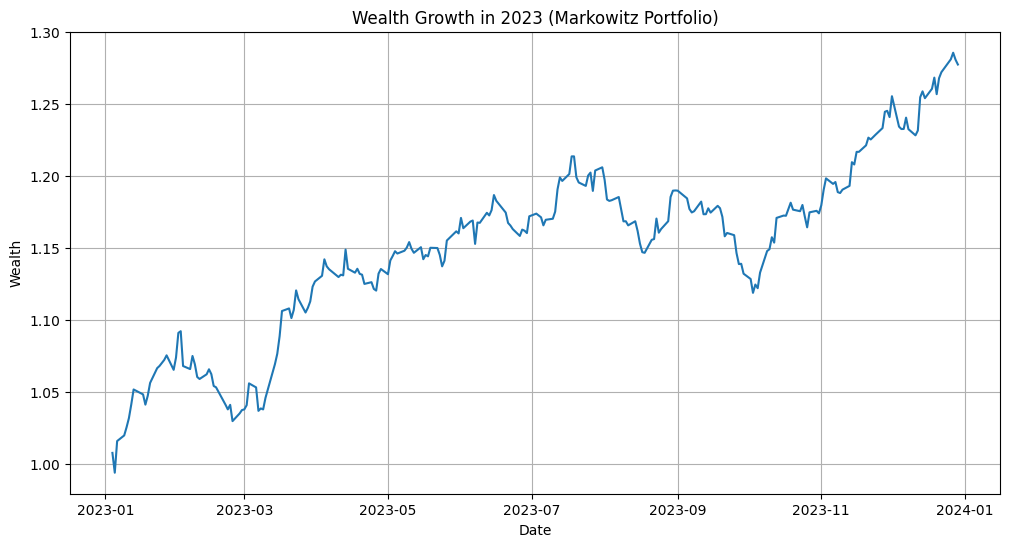

In [ ]:
# %% [11] Evaluate Portfolio on Test Set (2023-2024)

portfolio_daily_returns = test_returns.dot(optimal_weights)
wealth = (1 + portfolio_daily_returns).cumprod()

plt.figure(figsize=(12,6))
plt.plot(wealth)
plt.title('Wealth Growth in 2023 (Markowitz Portfolio)')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.grid(True)
plt.savefig("markowitz_wealth_growth.png")
plt.show()

In [ ]:
# Calculate performance metrics on 2023 test set

portfolio_return = portfolio_daily_returns.mean() * 252
portfolio_volatility = portfolio_daily_returns.std() * np.sqrt(252)
portfolio_sharpe = portfolio_return / portfolio_volatility

print("\nOut-of-Sample Performance (2023 Test Year):")
print(f"Annualized Return: {portfolio_return:.2%}")
print(f"Annualized Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {portfolio_sharpe:.2f}")

# Save test metrics

with open("markowitz_evaluation_metrics.txt", "w") as f:
    f.write(f"Annualized Return (2023 Test): {portfolio_return:.2%}\n")
    f.write(f"Annualized Volatility (2023 Test): {portfolio_volatility:.2%}\n")
    f.write(f"Sharpe Ratio (2023 Test): {portfolio_sharpe:.2f}\n")




Out-of-Sample Performance (2023 Test Year):
Annualized Return: 25.37%
Annualized Volatility: 10.76%
Sharpe Ratio: 2.36
